In [1]:
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

In [2]:
#read training data through pandas
x_train=pd.read_pickle('D:/ML/COMP551/comp-551-w2019-project-3-modified-mnist/train_images.pkl')
#normalize training data by toTensor and mean(0.5) and std(0.5). 
#Note that torchvision.transforms can be used. But I'm still not familiar with it...
x_train=x_train/255#-0.5)*2
#read training lable, the first column in y_train_r is id num, the second column is lable.
y_train_r = pd.read_csv('D:/ML/COMP551/comp-551-w2019-project-3-modified-mnist/train_labels.csv')
#tranfer numpy to tensor, in order to use gpu
y_train=torch.tensor(y_train_r.values[:,1])
#product train set.
trainset=[np.zeros((64,64)),np.zeros(1)]
for j in range(36000): #Note this part all data in train_images.pkl is load into trainset.
    # If valid set is needed, 40000 can be modifoed as the required length of trainset
    # Then do the same thing to validset, but the range need to be after trainset
    trainset.append([x_train[j],y_train[j]])
del trainset[0]
del trainset[0]
#copy 1 channel as 3 channels
for i in range(len(trainset)):
    trainset[i][0]=torch.tensor([np.array(trainset[i][0]),np.array(trainset[i][0]),np.array(trainset[i][0])])
#Get trainloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)



In [3]:
validset=[np.zeros((64,64)),np.zeros(1)]
for j in range(36000,40000): #Note this part all data in train_images.pkl is load into trainset.
    # If valid set is needed, 40000 can be modifoed as the required length of trainset
    # Then do the same thing to validset, but the range need to be after trainset
    validset.append([x_train[j],y_train[j]])
del validset[0]
del validset[0]
#copy 1 channel as 3 channels
for i in range(len(validset)):
    validset[i][0]=torch.tensor([np.array(validset[i][0]),np.array(validset[i][0]),np.array(validset[i][0])])
#Get trainloader
validloader = torch.utils.data.DataLoader(validset, batch_size=4,
                                          shuffle=True, num_workers=2)

In [4]:
# Preprocessing testset:
x_test=pd.read_pickle('D:/ML/COMP551/comp-551-w2019-project-3-modified-mnist/test_images.pkl')
x_test=x_test/255#-0.5)*2
testset=[np.zeros((64,64)),np.zeros(1)]
for j in range(len(x_test)):
    testset.append([x_test[j],y_train[j]])
del testset[0]
del testset[0]
for i in range(len(testset)):
    testset[i][0]=torch.tensor([np.array(testset[i][0]),np.array(testset[i][0]),np.array(testset[i][0])])
#preporcessing testloader
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                          shuffle=False, num_workers=2)

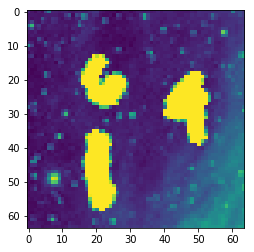

In [17]:
# function to show figures. This part has nothing to do with training.
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(x_test[100])
plt.show()

In [5]:
#*********************************************************************
# model part
import torchvision.models as models
# use pretrained model:
model = models.vgg16_bn(pretrained=True)
#import OrderedDicted to corectly align the network layers
#import nn to modify features

In [22]:
model.parameters

<bound method Module.parameters of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): 

In [6]:
from collections import OrderedDict
from torch import nn
#create classifier which fit our num of outputs
classifier=nn.Sequential(OrderedDict([('0', nn.Linear(in_features=25088, out_features=512, bias=True)),
                                      ('1', nn.ReLU()),
                                      ('2', nn.Dropout(p=0.5)),
                                      ('3', nn.Linear(in_features=512, out_features=102, bias=True)),
                                      ('4', nn.ReLU()),
                                      ('5', nn.Dropout(p=0.5)),
                                      ('6', nn.Linear(in_features=102, out_features=10, bias=True))
                                     ]))
#replace the model's classifier with this new classifier 
model.classifier = classifier

In [7]:
#import optimizer:
from torch import optim
#from parallel import DataParallelModel
#define criteria and optimizer
# Note that other losses or optimizers can also be tried
criteria = nn.CrossEntropyLoss()
#criteria  = DataParallelCriterion(criteria)
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)

In [8]:
#train model
#define training function
def train (model, loader, criterion, gpu):
    model.train()
    current_loss = 0
    current_correct = 0
    for train, y_train in iter(loader):
        if gpu:
            train, y_train = train.to('cuda'), y_train.to('cuda')
        optimizer.zero_grad()
        output = model.forward(train)
        _, preds = torch.max(output,1)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        current_loss += loss.item()*train.size(0)
        current_correct += torch.sum(preds == y_train.data)
        #check if the training is correct: 
        #print(preds,y_train,current_correct,current_loss)
    epoch_loss = current_loss / len(loader)
    # devide 4 because we read 4 data everytime
    epoch_acc = current_correct.double() / len(loader)/4
        
    return epoch_loss, epoch_acc

In [9]:
#define validation function
def validation (model, loader, criterion, gpu):
    model.eval()
    valid_loss = 0
    valid_correct = 0
    for valid, y_valid in iter(loader):
        if gpu:
            valid, y_valid = valid.to('cuda'), y_valid.to('cuda')
        output = model.forward(valid)
        _, preds = torch.max(output,1)
        valid_loss += criterion(output, y_valid).item()*valid.size(0)
        valid_correct += torch.sum(preds == y_valid.data)
    
    epoch_loss = valid_loss / len(loader)
    epoch_acc = valid_correct.double() / len(loader)/4
    
    return epoch_loss, epoch_acc

In [10]:
#define test function
def test (model, loader, criterion, gpu):
    model.eval()
    valid_loss = 0
    valid_correct = 0
    i=0
    pred=torch.zeros(len(loader))
    for test, y_train in iter(loader):
        if gpu:
            test = test.to('cuda')
        output = model.forward(test)
        _, preds = torch.max(output,1)
        pred[i]=preds
        i=i+1    
    return pred

In [11]:
# training
#send model to gpu. If not send it to GPU, delete next line.
from torch.nn import DataParallel
model.to('cuda')
#model= torch.nn.DataParallel(model)
#Initialize training params  
#freeze gradient parameters in pretrained model
for param in model.parameters():
    param.require_grad = False
# define number of epochs
epochs = 20
epoch = 0

for e in range(epochs):
    epoch +=1
    print(epoch)
#train:    
    with torch.set_grad_enabled(True):
        epoch_train_loss, epoch_train_acc = train(model,trainloader, criteria, 1)
    print("Epoch: {} Train Loss : {:.4f}  Train Accuracy: {:.4f}".format(epoch,epoch_train_loss,epoch_train_acc))
#Valid, Activate next code when validation result is needed:
    with torch.no_grad():
        epoch_val_loss, epoch_val_acc = validation(model, validloader, criteria, 1)
    print("Epoch: {} Validation Loss : {:.4f}  Validation Accuracy {:.4f}".format(epoch,epoch_val_loss,epoch_val_acc))

1
Epoch: 1 Train Loss : 4.7283  Train Accuracy: 0.6118
Epoch: 1 Validation Loss : 1.1335  Validation Accuracy 0.9297
2
Epoch: 2 Train Loss : 1.4933  Train Accuracy: 0.9107
Epoch: 2 Validation Loss : 0.8274  Validation Accuracy 0.9507
3
Epoch: 3 Train Loss : 0.9595  Train Accuracy: 0.9436
Epoch: 3 Validation Loss : 0.6536  Validation Accuracy 0.9565
4
Epoch: 4 Train Loss : 0.6775  Train Accuracy: 0.9588
Epoch: 4 Validation Loss : 0.6326  Validation Accuracy 0.9625
5
Epoch: 5 Train Loss : 0.5116  Train Accuracy: 0.9689
Epoch: 5 Validation Loss : 0.8861  Validation Accuracy 0.9480
6
Epoch: 6 Train Loss : 0.4230  Train Accuracy: 0.9733
Epoch: 6 Validation Loss : 0.5768  Validation Accuracy 0.9673
7
Epoch: 7 Train Loss : 0.3487  Train Accuracy: 0.9796
Epoch: 7 Validation Loss : 0.6911  Validation Accuracy 0.9633
8
Epoch: 8 Train Loss : 0.2841  Train Accuracy: 0.9828
Epoch: 8 Validation Loss : 0.5448  Validation Accuracy 0.9630
9
Epoch: 9 Train Loss : 0.2604  Train Accuracy: 0.9850
Epoch: 9 

In [12]:
#get prediction result for test data
predict=test(model,testloader, criteria, 1)
predict.numpy()

array([7., 1., 6., ..., 7., 7., 9.], dtype=float32)

In [13]:
#Save predict result to test file. Note the output file just have category column right now.
#To submit it, one column named id need to be added to the excel file.
import numpy
numpy.savetxt("test.csv", predict, delimiter=",")